# Visión general

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

La tarea consiste en crear un modelo de *Machine Learning* que sea capaz de predecir el precio medio de viviendas por distrito de California. 

Para ello, usaremos un *dataset* de datos de cada bloque censal de California del censo de 1990, con algunas modificaciones con fines didácticos. Además, el dataset no es actual, lo cual es un sesgo que hace este dataset poco útil para el uso que buscamos, pero es un buen ejemplo para aprender a trabajar con datos reales si dejamos de lado ese dato (aunque es muy importante identificarlo).

Este [dataset se puede descargar de Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), junto con los detalles de su contenido y además se pueden encontrar múltiples notebooks como este con diferentes análisis y procesamientos de los datos.

## Primer acercamiento a los datos

Partimos del *dataset* en un fichero csv, que cargamos en un **DataFrame** de **pandas**.

In [1]:
import pandas as pd
housing = pd.read_csv("./data/housing.csv")

In [2]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observamos que el dataset tiene 10 columnas, y 20640 filas. Son pocas filas para un dataset de *Machine Learning*, pero es un buen ejemplo para aprender. Podríamos trabajar con ficheros mucho más grandes, y llegado el caso de que el dataset sea demasiado grande, tendríamos que utilizar *frameworks* de **Big Data**.

In [4]:
housing.isnull().sum() # Revisamos el número de valores nulos

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Todas las columnas son numéricas, excepto 'ocean_proximity', que es de tipo "object". Este tipo puede contener cualquier objeto de Python, pero al haber sido leído desde un CSV sabemos que es texto. Analizamos sus valores para poder confirmar que se trata de una **variable categórica** con 5 valores posibles indicando la proximidad al océano.

In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Utilizamos el método ```describe()``` para obtener un resumen de las estadísticas de cada columna numérica. Los valores nulos serán ignorados al calcular estas estadísticas.
También podemos usar el método ```hist()``` para obtener un histograma de cada columna numérica y ver su distribución. 

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

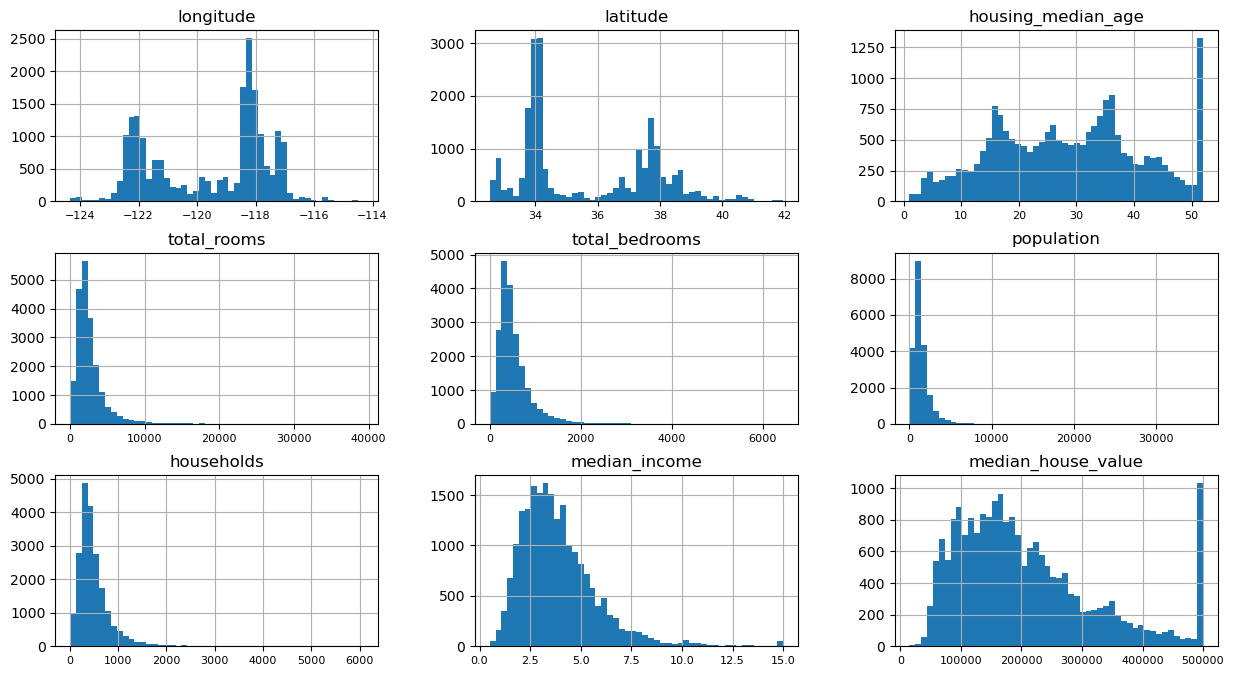

In [7]:
import matplotlib.pyplot as plt

_ =housing.hist(bins=50, figsize=(15, 8),
                xlabelsize=8) # Reducimos el tamaño de las etiquetas del eje x para que no se superpongan

Puede llamarnos la atención la columna 'median_income' (ingresos medios), que no está expresada en dólares. Tras consultar la documentación, vemos que los valores de esta columna han sido escalados y limitados a un rango de 0.5 a 15.0 (de hecho, 15.0 es el valor máximo que puede tomar) y que representan decenas de miles de dólares (por ejemplo, 3 realmente significa 30.000 USD).

Además, las columnas 'housing_median_age', 'median_house_value' también han sido limitadas (***capping***). Puede deducirse de la larga columna que vemos a la derecha de sus histogramas. Los valores por encima se han convertido a ese valor lí­mite. Este proceso a veces puede ser beneficioso por razones que veremos más adelante, pero también podría suponer un problema especialmente en "median_house_value", ya que representa la salida que queremos predecir. Nuestros algoritmos pueden aprender erróneamente que los precios nunca superan ese lí­mite. En estos casos deberíamos consultar si esto puede ser un problema para los usos de nuestro modelo. Si necesitamos predicciones precisas incluso más allá de 500,000 USD, entonces necesitaríamos buscar las etiquetas reales de los distritos con un 'median_house_value' de 500001. Si no podemos obtenerlas, entonces debemos eliminar esos distritos de los datos de entrenamiento y validación (y también de los datos de prueba, ya que no queremos evaluar nuestro modelo con ejemplos que no se usarán en la práctica).

Es común que tengamos que trabajar con datos que han sido preprocesados, es importante entender qué criterios se han seguido, y si es posible, obtener los datos originales y preprocesarlos nosotros mismos.

También podemos ver que varios histogramas tienen colas más gruesas hacia la derecha<!--TODO-->. Esto puede hacer que sea más difícil que algunos algoritmos de *Machine Learning* detecten patrones. Intentaremos transformar estas variables más adelante para que tengan una distribución más simétrica.

Esto se puede observar también en la relación entre la media y la mediana. Por ejemplo, la media en 'total_bedrooms' es 537.87, y la mediana es 435.00. Esto nos indica que la distribución de los valores de esta variable está sesgada hacia la derecha, ya que la mediana es menor que la media. Esto es importante tenerlo en cuenta, ya que puede afectar a la forma en que tratamos los valores no disponibles.

Otra cosa que puede llamarnos la atención es la columna 'ocean_proximity', que no aparece en el resumen de estadísticas. Esto es porque es una **variable categórica**, no numérica. No tiene sentido calcular estadísticas sobre ella.

## Enmarcando el problema

Tenemos por tanto el objetivo de entrenar un modelo de *Machine Learning* que sea capaz de predecir el precio medio de las viviendas en cualquier distrito de California. Para dicho entrenamiento tenemos un dataset con 20640 filas, cada una de las cuales representa un distrito de California, y 10 columnas con información sobre cada distrito. Una de las columnas es el precio medio de las viviendas en dicho distrito, que es la que queremos predecir; es por tanto la **variable objetivo** o ***target variable***. Las otras 9 columnas son las **variables independientes** o ***features*** (caracterí­sticas).

Al tener una variable objetivo (una **etiqueta** para cada muestra) **continua**, estamos ante un problema de **aprendizaje supervisado**. Además, como dicha variable es un valor numérico continuo, estamos ante un problema de **regresión**.

## Selección de medida de rendimiento

Para evaluar el rendimiento de nuestro modelo, usaremos la raí­z del error cuadrático medio (RMSE), que es una medida de rendimiento (***performance measure***) muy común en problemas de regresión, y es la que se usa por defecto en la clase `LinearRegression` de Scikit-Learn. 
<!-- TODO: Enlazar con el notebook de regresión. Clarificar performance measure vs cost functions vs otras -->